# Random Forest Classifier - Predicting Future Stock Price

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/draganbogatic/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# Read in stock historical prices and calculate daily return
stock_prices = pd.read_csv("../Resources/stock_historical_prices.csv")
stock_prices = stock_prices.set_index("Date")
stock_prices.dropna(inplace=True)
stock_prices.head()

,Adj Close
Date,
2015-08-07,143.550003
2015-08-10,143.419998
2015-08-11,142.800003
2015-08-12,141.600006
2015-08-13,141.949997


In [4]:
# Drop NAs and calculate daily percent return
stock_prices['Daily_Return'] = stock_prices['Adj Close'].dropna().pct_change()
stock_prices.head()

,Adj Close,Daily_Return
Date,,
2015-08-07,143.550003,NaN
2015-08-10,143.419998,-0.000906
2015-08-11,142.800003,-0.004323
2015-08-12,141.600006,-0.008403
2015-08-13,141.949997,0.002472


In [5]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
stock_prices['Fast_Close'] = stock_prices['Adj Close'].ewm(halflife=short_window).mean()
stock_prices['Slow_Close'] = stock_prices['Adj Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
stock_prices['Crossover_Long'] = np.where(stock_prices['Fast_Close'] > stock_prices['Slow_Close'], 1.0, 0.0)
stock_prices['Crossover_Short'] = np.where(stock_prices['Fast_Close'] < stock_prices['Slow_Close'], -1.0, 0.0)
stock_prices['Crossover_Signal'] = stock_prices['Crossover_Long'] + stock_prices['Crossover_Short']

stock_prices.tail()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal
Date,,,,,,,
2021-07-13,279.209991,-0.003213,279.242290,279.934462,0.0,-1.0,-1.0
2021-07-14,278.309998,-0.003223,278.776144,279.825676,0.0,-1.0,-1.0
2021-07-15,279.720001,0.005066,279.248073,279.818600,0.0,-1.0,-1.0
2021-07-16,277.899994,-0.006507,278.574033,279.690116,0.0,-1.0,-1.0
2021-07-19,272.660004,-0.018856,275.617018,279.219331,0.0,-1.0,-1.0


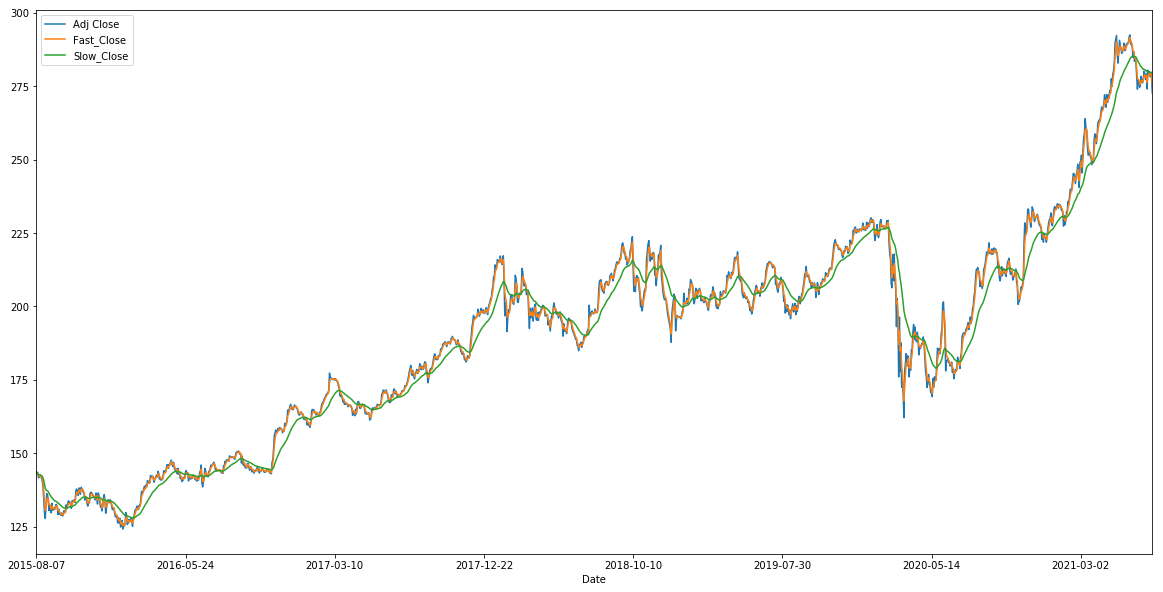

In [6]:
# Plot EMA
stock_prices[['Adj Close', 'Fast_Close', 'Slow_Close']].plot(figsize=(20,10))

In [7]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
stock_prices['Fast_Vol'] = stock_prices['Daily_Return'].ewm(halflife=short_vol_window).std()
stock_prices['Slow_Vol'] = stock_prices['Daily_Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
stock_prices['Vol_Trend_Long'] = np.where(stock_prices['Fast_Vol'] < stock_prices['Slow_Vol'], 1.0, 0.0)
stock_prices['Vol_Trend_Short'] = np.where(stock_prices['Fast_Vol'] > stock_prices['Slow_Vol'], -1.0, 0.0) 
stock_prices['Vol_Trend_Signal'] = stock_prices['Vol_Trend_Long'] + stock_prices['Vol_Trend_Short']

stock_prices.head()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal
Date,,,,,,,,,,,,
2015-08-07,143.550003,NaN,143.550003,143.550003,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2015-08-10,143.419998,-0.000906,143.463333,143.482749,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2015-08-11,142.800003,-0.004323,143.084287,143.239223,0.0,-1.0,-1.0,0.002416,0.002416,0.0,0.0,0.0
2015-08-12,141.600006,-0.008403,142.292671,142.785879,0.0,-1.0,-1.0,0.003691,0.003760,1.0,0.0,1.0
2015-08-13,141.949997,0.002472,142.115807,142.594763,0.0,-1.0,-1.0,0.005974,0.004786,0.0,-1.0,-1.0


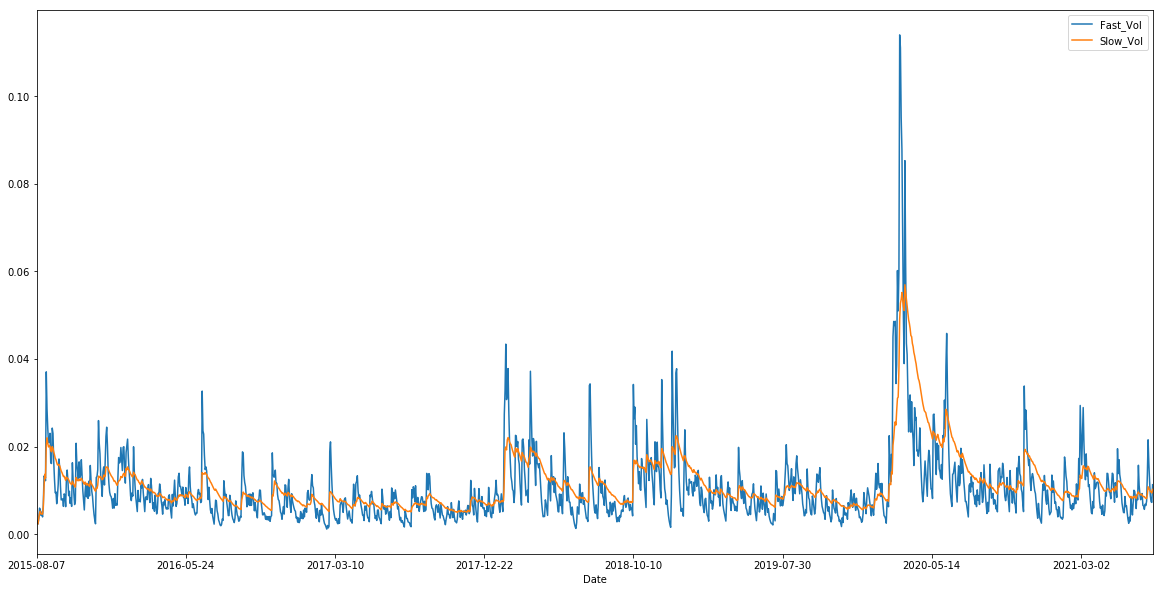

In [8]:
# Plot EMA volatility
stock_prices[['Fast_Vol', 'Slow_Vol']].plot(figsize=(20,10))

In [9]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
stock_prices['Bollinger_Mid_Band'] = stock_prices['Adj Close'].rolling(window=bollinger_window).mean()
stock_prices['Bollinger_Std'] = stock_prices['Adj Close'].rolling(window=bollinger_window).std()

# Calculate upper and lowers bands of bollinger band
stock_prices['Bollinger_Upper_Band']  = stock_prices['Bollinger_Mid_Band'] + (stock_prices['Bollinger_Std'] * 1)
stock_prices['Bollinger_Lower_Band']  = stock_prices['Bollinger_Mid_Band'] - (stock_prices['Bollinger_Std'] * 1)

# Calculate bollinger band trading signal
stock_prices['Bollinger_Long'] = np.where(stock_prices['Adj Close'] < stock_prices['Bollinger_Lower_Band'], 1.0, 0.0)
stock_prices['Bollinger_Short'] = np.where(stock_prices['Adj Close'] > stock_prices['Bollinger_Upper_Band'], -1.0, 0.0)
stock_prices['Bollinger_Signal'] = stock_prices['Bollinger_Long'] + stock_prices['Bollinger_Short']

stock_prices.head()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal,Bollinger_Mid_Band,Bollinger_Std,Bollinger_Upper_Band,Bollinger_Lower_Band,Bollinger_Long,Bollinger_Short,Bollinger_Signal
Date,,,,,,,,,,,,,,,,,,,
2015-08-07,143.550003,NaN,143.550003,143.550003,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2015-08-10,143.419998,-0.000906,143.463333,143.482749,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2015-08-11,142.800003,-0.004323,143.084287,143.239223,0.0,-1.0,-1.0,0.002416,0.002416,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2015-08-12,141.600006,-0.008403,142.292671,142.785879,0.0,-1.0,-1.0,0.003691,0.003760,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2015-08-13,141.949997,0.002472,142.115807,142.594763,0.0,-1.0,-1.0,0.005974,0.004786,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


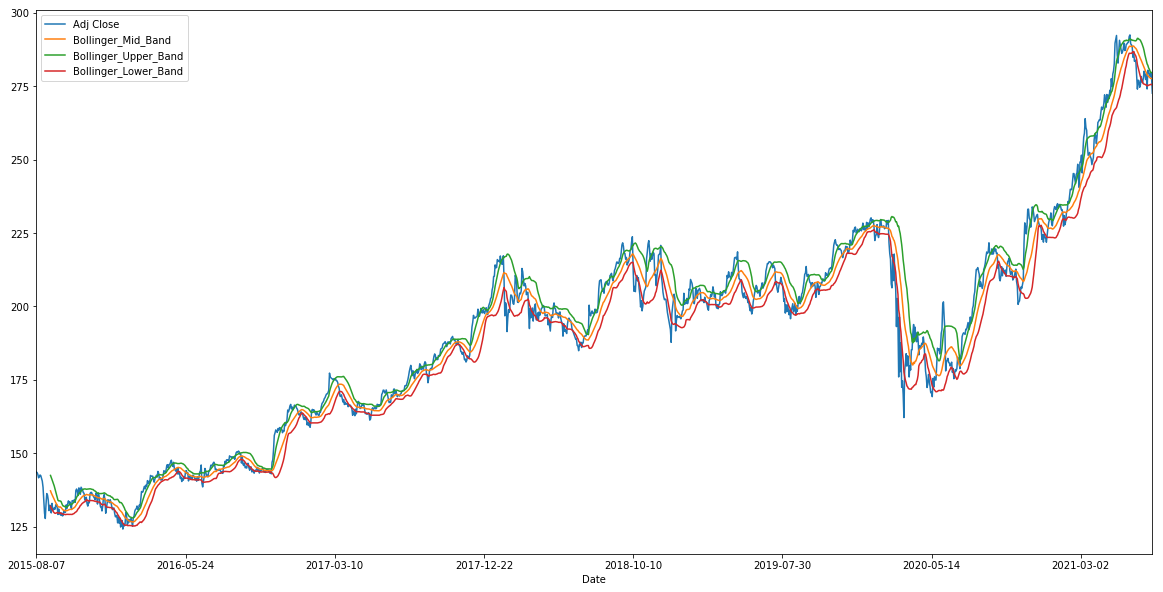

In [10]:
# Plot the Bollinger Bands for closing prices
stock_prices[['Adj Close','Bollinger_Mid_Band','Bollinger_Upper_Band','Bollinger_Lower_Band']].plot(figsize=(20,10))

In [11]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
stock_prices['Positive_Return'] = np.where(stock_prices['Daily_Return'] > 0, 1.0, 0.0)
stock_prices = stock_prices.dropna()
stock_prices.tail()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal,Bollinger_Mid_Band,Bollinger_Std,Bollinger_Upper_Band,Bollinger_Lower_Band,Bollinger_Long,Bollinger_Short,Bollinger_Signal,Positive_Return
Date,,,,,,,,,,,,,,,,,,,,
2021-07-13,279.209991,-0.003213,279.242290,279.934462,0.0,-1.0,-1.0,0.012086,0.010166,0.0,-1.0,-1.0,278.141499,2.686823,280.828323,275.454676,0.0,0.0,0.0,0.0
2021-07-14,278.309998,-0.003223,278.776144,279.825676,0.0,-1.0,-1.0,0.008764,0.009852,1.0,0.0,1.0,277.859999,2.316784,280.176783,275.543215,0.0,0.0,0.0,0.0
2021-07-15,279.720001,0.005066,279.248073,279.818600,0.0,-1.0,-1.0,0.007434,0.009615,1.0,0.0,1.0,277.690500,2.017097,279.707597,275.673403,0.0,-1.0,-1.0,1.0
2021-07-16,277.899994,-0.006507,278.574033,279.690116,0.0,-1.0,-1.0,0.007278,0.009435,1.0,0.0,1.0,277.650999,2.004188,279.655187,275.646812,0.0,0.0,0.0,0.0
2021-07-19,272.660004,-0.018856,275.617018,279.219331,0.0,-1.0,-1.0,0.011317,0.010251,0.0,-1.0,-1.0,277.581999,2.153261,279.735261,275.428738,1.0,0.0,1.0,0.0


In [12]:
X = stock_prices[["Crossover_Signal","Vol_Trend_Signal","Bollinger_Signal"]]
X_train = X[:"2021"]

In [13]:
y = stock_prices["Positive_Return"]
y_train = y[:"2021"]

In [14]:
X_test = X["2021":]
y_test = y["2021":]

In [15]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [16]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [17]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
# Create the decision tree classifier instance
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# Fit the model
model = model.fit(X_train_scaled, y_train)

In [19]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [20]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [21]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,40,21
Actual 1,22,53


Accuracy Score : 0.6838235294117647
Classification Report
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65        61
         1.0       0.72      0.71      0.71        75

    accuracy                           0.68       136
   macro avg       0.68      0.68      0.68       136
weighted avg       0.68      0.68      0.68       136



In [22]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive_Return,Predicted Value
Date,,
2021-01-04,0.0,0.0
2021-01-05,0.0,0.0
2021-01-06,1.0,1.0
2021-01-07,1.0,1.0
2021-01-08,1.0,1.0
2021-01-11,0.0,1.0
2021-01-12,0.0,1.0
2021-01-13,1.0,1.0
2021-01-14,1.0,1.0


In [92]:
# Random Forest shows approx. 68% overall accuracy with prediction of negative return and approx. 72% accuracy with prediction of positive return. It would be beneficial to lower recall value to reduce the number of false positives.

# Maybe varying the length of the series and tweaking model hyperparameters will further improve model accuracy.